In [2]:
%load_ext autoreload
%autoreload 2
!CUDA_VISIBLE_DEVICES=7 
import sys
sys.path.insert(0, '/home/user/LQ/B_Signal/Transparent_information_fusion/post/')  # 添加上一级目录到系统路径

from A1_plot_config import configure_matplotlib
configure_matplotlib(style='ieee', font_lang='en')
# %reload_ext autoreload

import os

# 修改当前工作目录
root_dir = '/home/user/LQ/B_Signal/Transparent_information_fusion/'
os.chdir(root_dir)

## load

In [3]:
from A3_load_model import load_models,predict_from_loader

# root_dir = '/home/user/LQ/B_Signal/Transparent_information_fusion/'
config_dir = 'configs/DIRG_020/config_NNSPN.yaml'
best_model_path = '/home/user/LQ/B_Signal/Transparent_information_fusion/save/task_DIRG_020_basic/model_NNSPN/bestmodel_NNSPNtime30-21-05-14_lr0.001_epochs300_scale4_datasetDIRG_020_basic/model-epoch=181-val_loss=0.0015-val_acc=1.0000-l1_loss=0.0000.ckpt' 


TSPN, test_dataloader,args = load_models(config_dir,best_model_path=best_model_path)

# y_true,y_pred = predict_from_loader(TSPN,test_dataloader)




/home/user/anaconda3/envs/LQ1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 17


Running experiment: post_time2024-07-02-10-41_lr0.001_epochs300_scale4_l1norm0.001_datasetDIRG_020_basic_seed17
# build signal processing layers
# build feature extractor layers
# build classifier


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading best model from /home/user/LQ/B_Signal/Transparent_information_fusion/save/task_DIRG_020_basic/model_NNSPN/bestmodel_NNSPNtime30-21-05-14_lr0.001_epochs300_scale4_datasetDIRG_020_basic/model-epoch=181-val_loss=0.0015-val_acc=1.0000-l1_loss=0.0000.ckpt


In [5]:
from A4_confusion_plus_noise_task import heatmap_confusion,plot_accuracy_vs_snr
heatmap_confusion(predictions = y_pred, test_labels = y_true, args = args,plot_dir='./plot', name='NNSPN')


NameError: name 'y_pred' is not defined

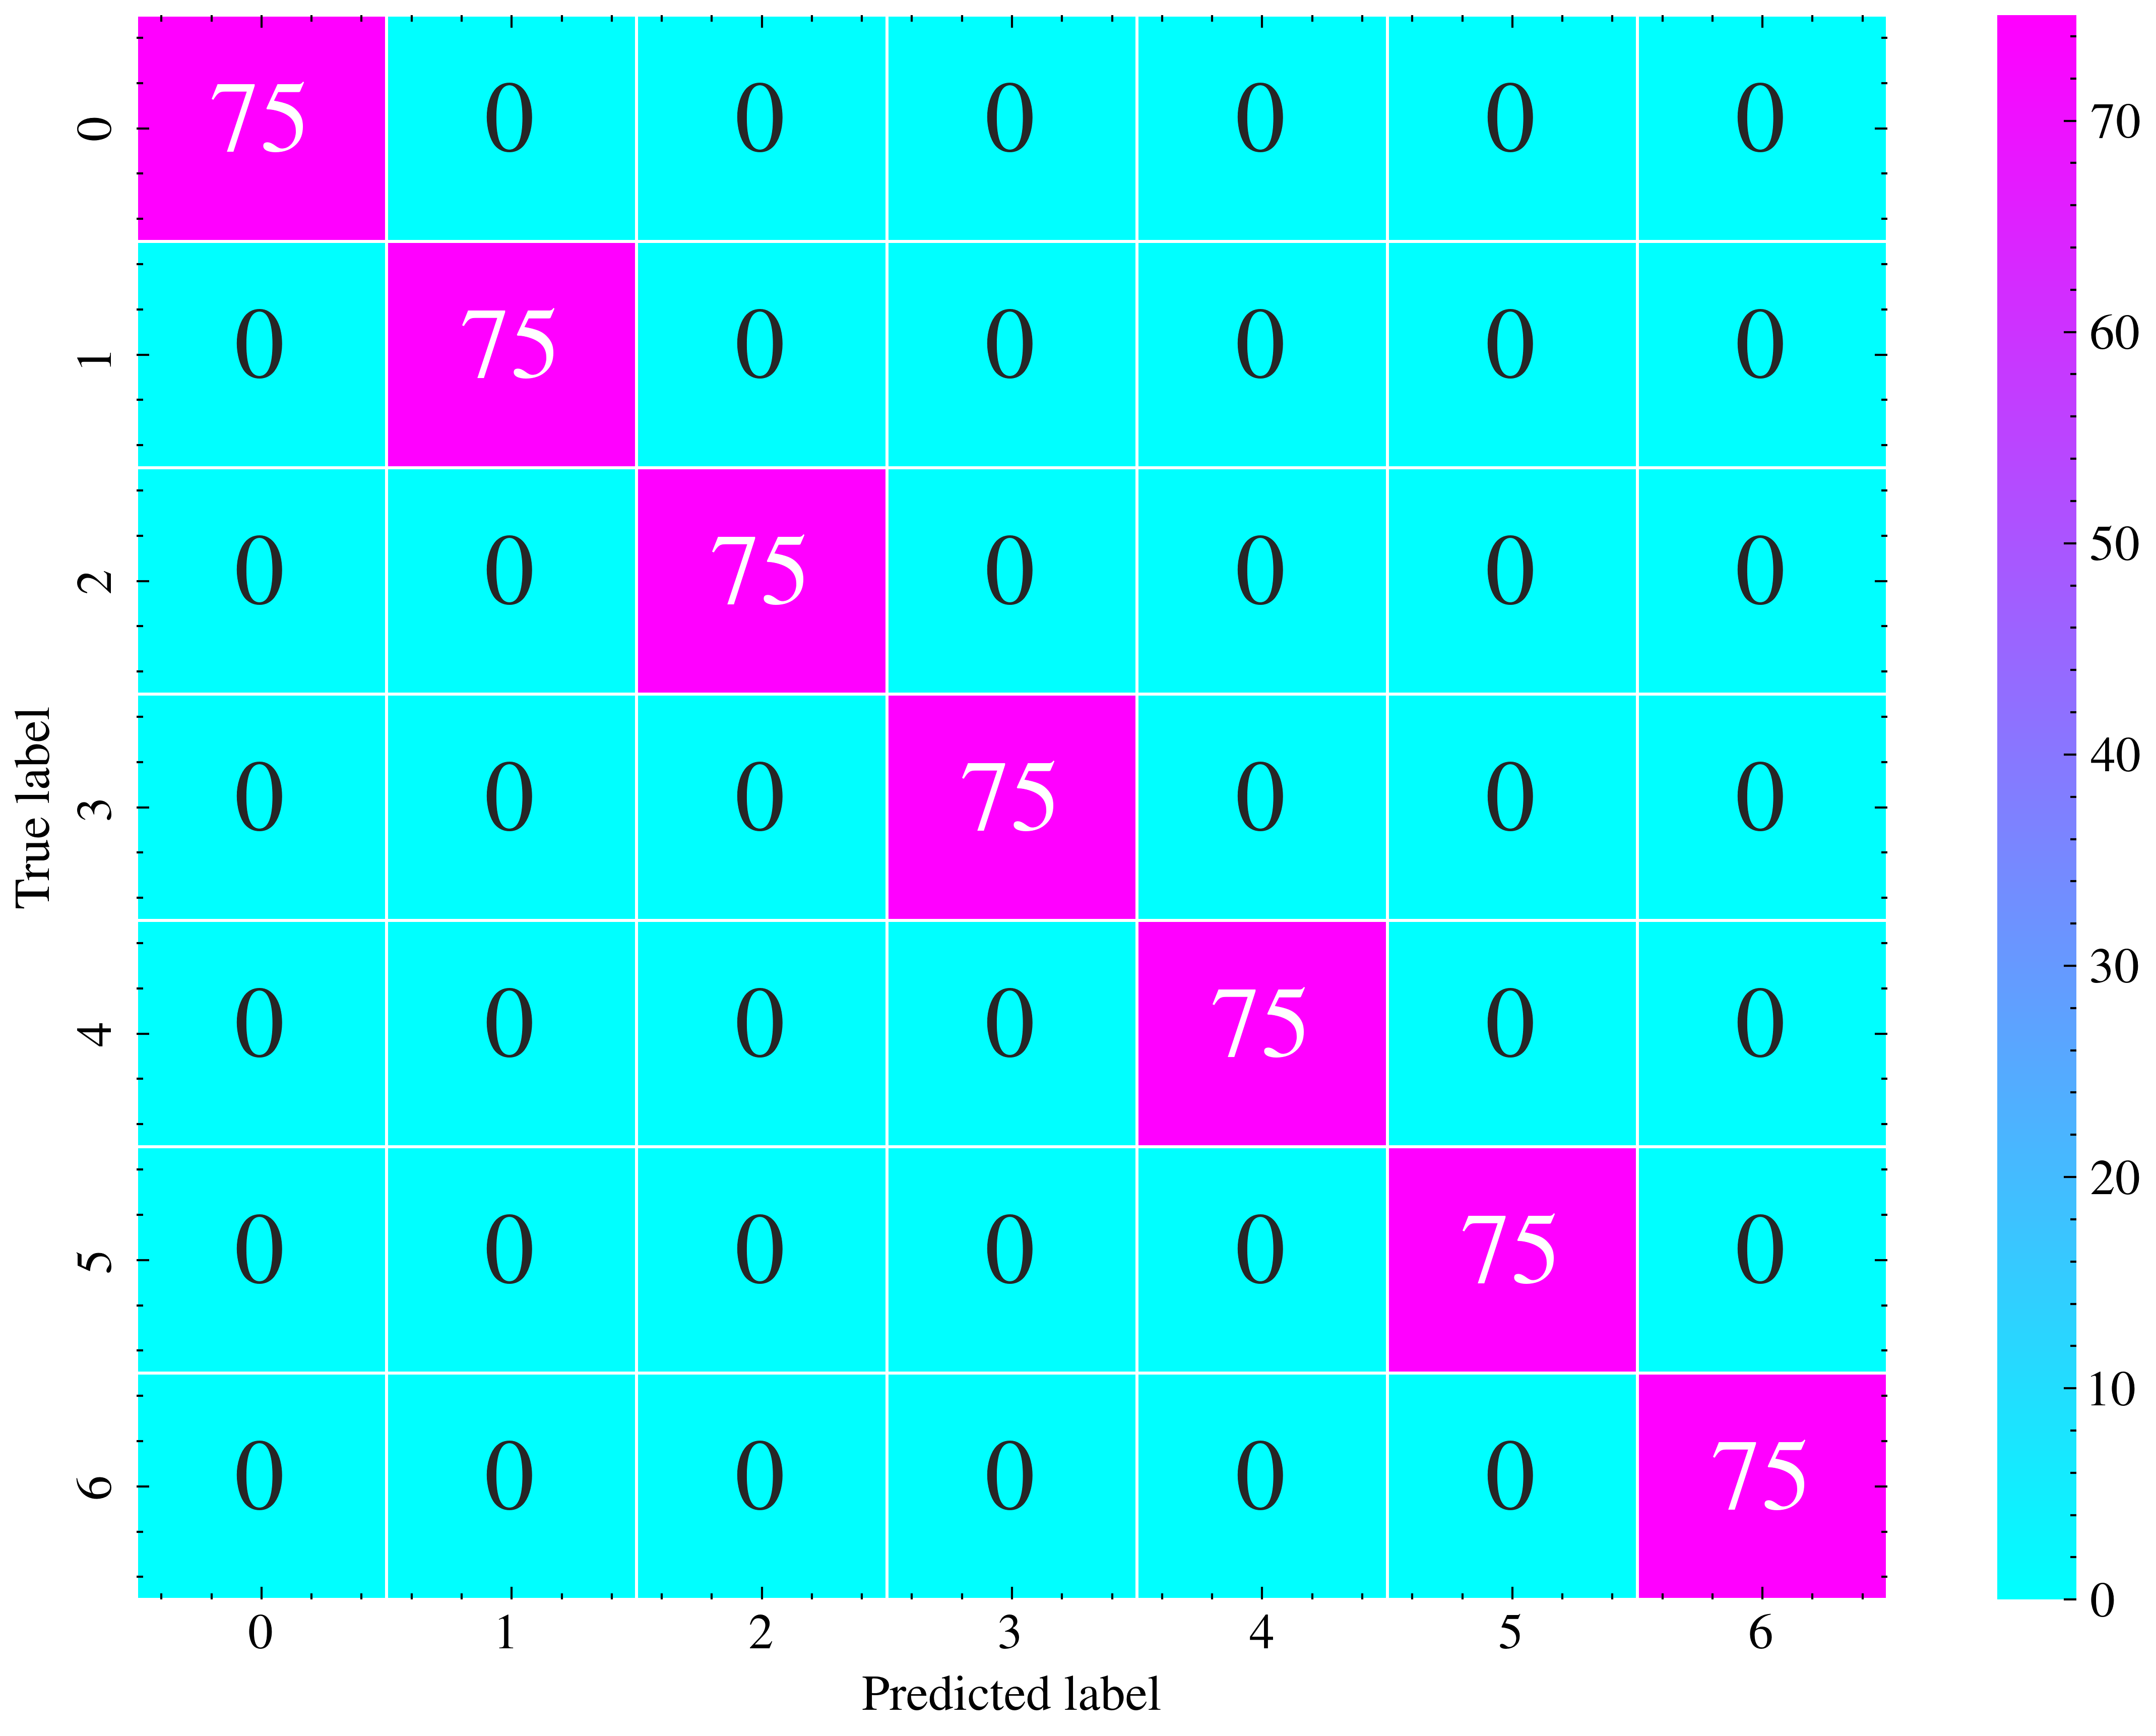

array([[75,  0,  0,  0,  0,  0,  0],
       [ 0, 75,  0,  0,  0,  0,  0],
       [ 0,  0, 75,  0,  0,  0,  0],
       [ 0,  0,  0, 75,  0,  0,  0],
       [ 0,  0,  0,  0, 75,  0,  0],
       [ 0,  0,  0,  0,  0, 75,  0],
       [ 0,  0,  0,  0,  0,  0, 75]])

In [14]:
from A4_confusion_plus_noise_task import heatmap_confusion,plot_accuracy_vs_snr
y_true,y_pred = predict_from_loader(MWA.cuda(),test_dataloader)
heatmap_confusion(predictions = y_pred, test_labels = y_true, args = args,plot_dir='./plot', name='MWA')

In [10]:
from A4_confusion_plus_noise_task import plot_accuracy_vs_snr


Resnet_condfig_dir = 'configs/DIRG_020/config_Resnet.yaml'
MWA_config_dir = 'configs/DIRG_020/config_MWA_CNN.yaml'
Sincnet_config_dir = 'configs/DIRG_020/config_Sincnet.yaml'
WKN_config_dir = 'configs/DIRG_020/config_WKN.yaml'

resnet, test_dataloader, args = load_models(Resnet_condfig_dir,best_model_path='save/Attention_paper/basic/Resnet/model-epoch=247-val_loss=0.0028-val_acc=1.0000-l1_loss=0.0000.ckpt')
MWA,_,_ = load_models(MWA_config_dir,best_model_path='save/Attention_paper/basic/CNN/model-epoch=122-val_loss=0.0024-val_acc=1.0000-l1_loss=0.0000.ckpt')
Sincnet,_,_ = load_models(Sincnet_config_dir,best_model_path='save/Attention_paper/basic/Sinc_net/model-epoch=278-val_loss=0.0013-val_acc=1.0000-l1_loss=0.0000.ckpt')
WKN,_,_ = load_models(WKN_config_dir,best_model_path='save/Attention_paper/basic/WKN/model-epoch=211-val_loss=0.0042-val_acc=1.0000-l1_loss=0.0000.ckpt')





Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Running experiment: post_time2024-07-02-10-43_lr0.001_epochs300_scale4_l1norm0.001_datasetDIRG_020_basic_seed17


Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading best model from save/Attention_paper/basic/Resnet/model-epoch=247-val_loss=0.0028-val_acc=1.0000-l1_loss=0.0000.ckpt
Running experiment: post_time2024-07-02-10-43_lr0.001_epochs300_scale4_l1norm0.001_datasetDIRG_020_basic_seed17


Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading best model from save/Attention_paper/basic/CNN/model-epoch=122-val_loss=0.0024-val_acc=1.0000-l1_loss=0.0000.ckpt
Running experiment: post_time2024-07-02-10-43_lr0.001_epochs300_scale32_l1norm0.001_datasetDIRG_020_basic_seed17


Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading best model from save/Attention_paper/basic/Sinc_net/model-epoch=278-val_loss=0.0013-val_acc=1.0000-l1_loss=0.0000.ckpt
Running experiment: post_time2024-07-02-10-43_lr0.001_epochs300_scale4_l1norm0.001_datasetDIRG_020_basic_seed17
Loading best model from save/Attention_paper/basic/WKN/model-epoch=211-val_loss=0.0042-val_acc=1.0000-l1_loss=0.0000.ckpt


In [7]:
from pytorch_lightning import seed_everything
seed_everything(args.seed)
# test_dataloader.dataset.flag = 'test'  #
# test_dataloader.dataset.data_create()
data = test_dataloader.dataset.selected_data
labels = test_dataloader.dataset.selected_labels

Seed set to 17


## plot

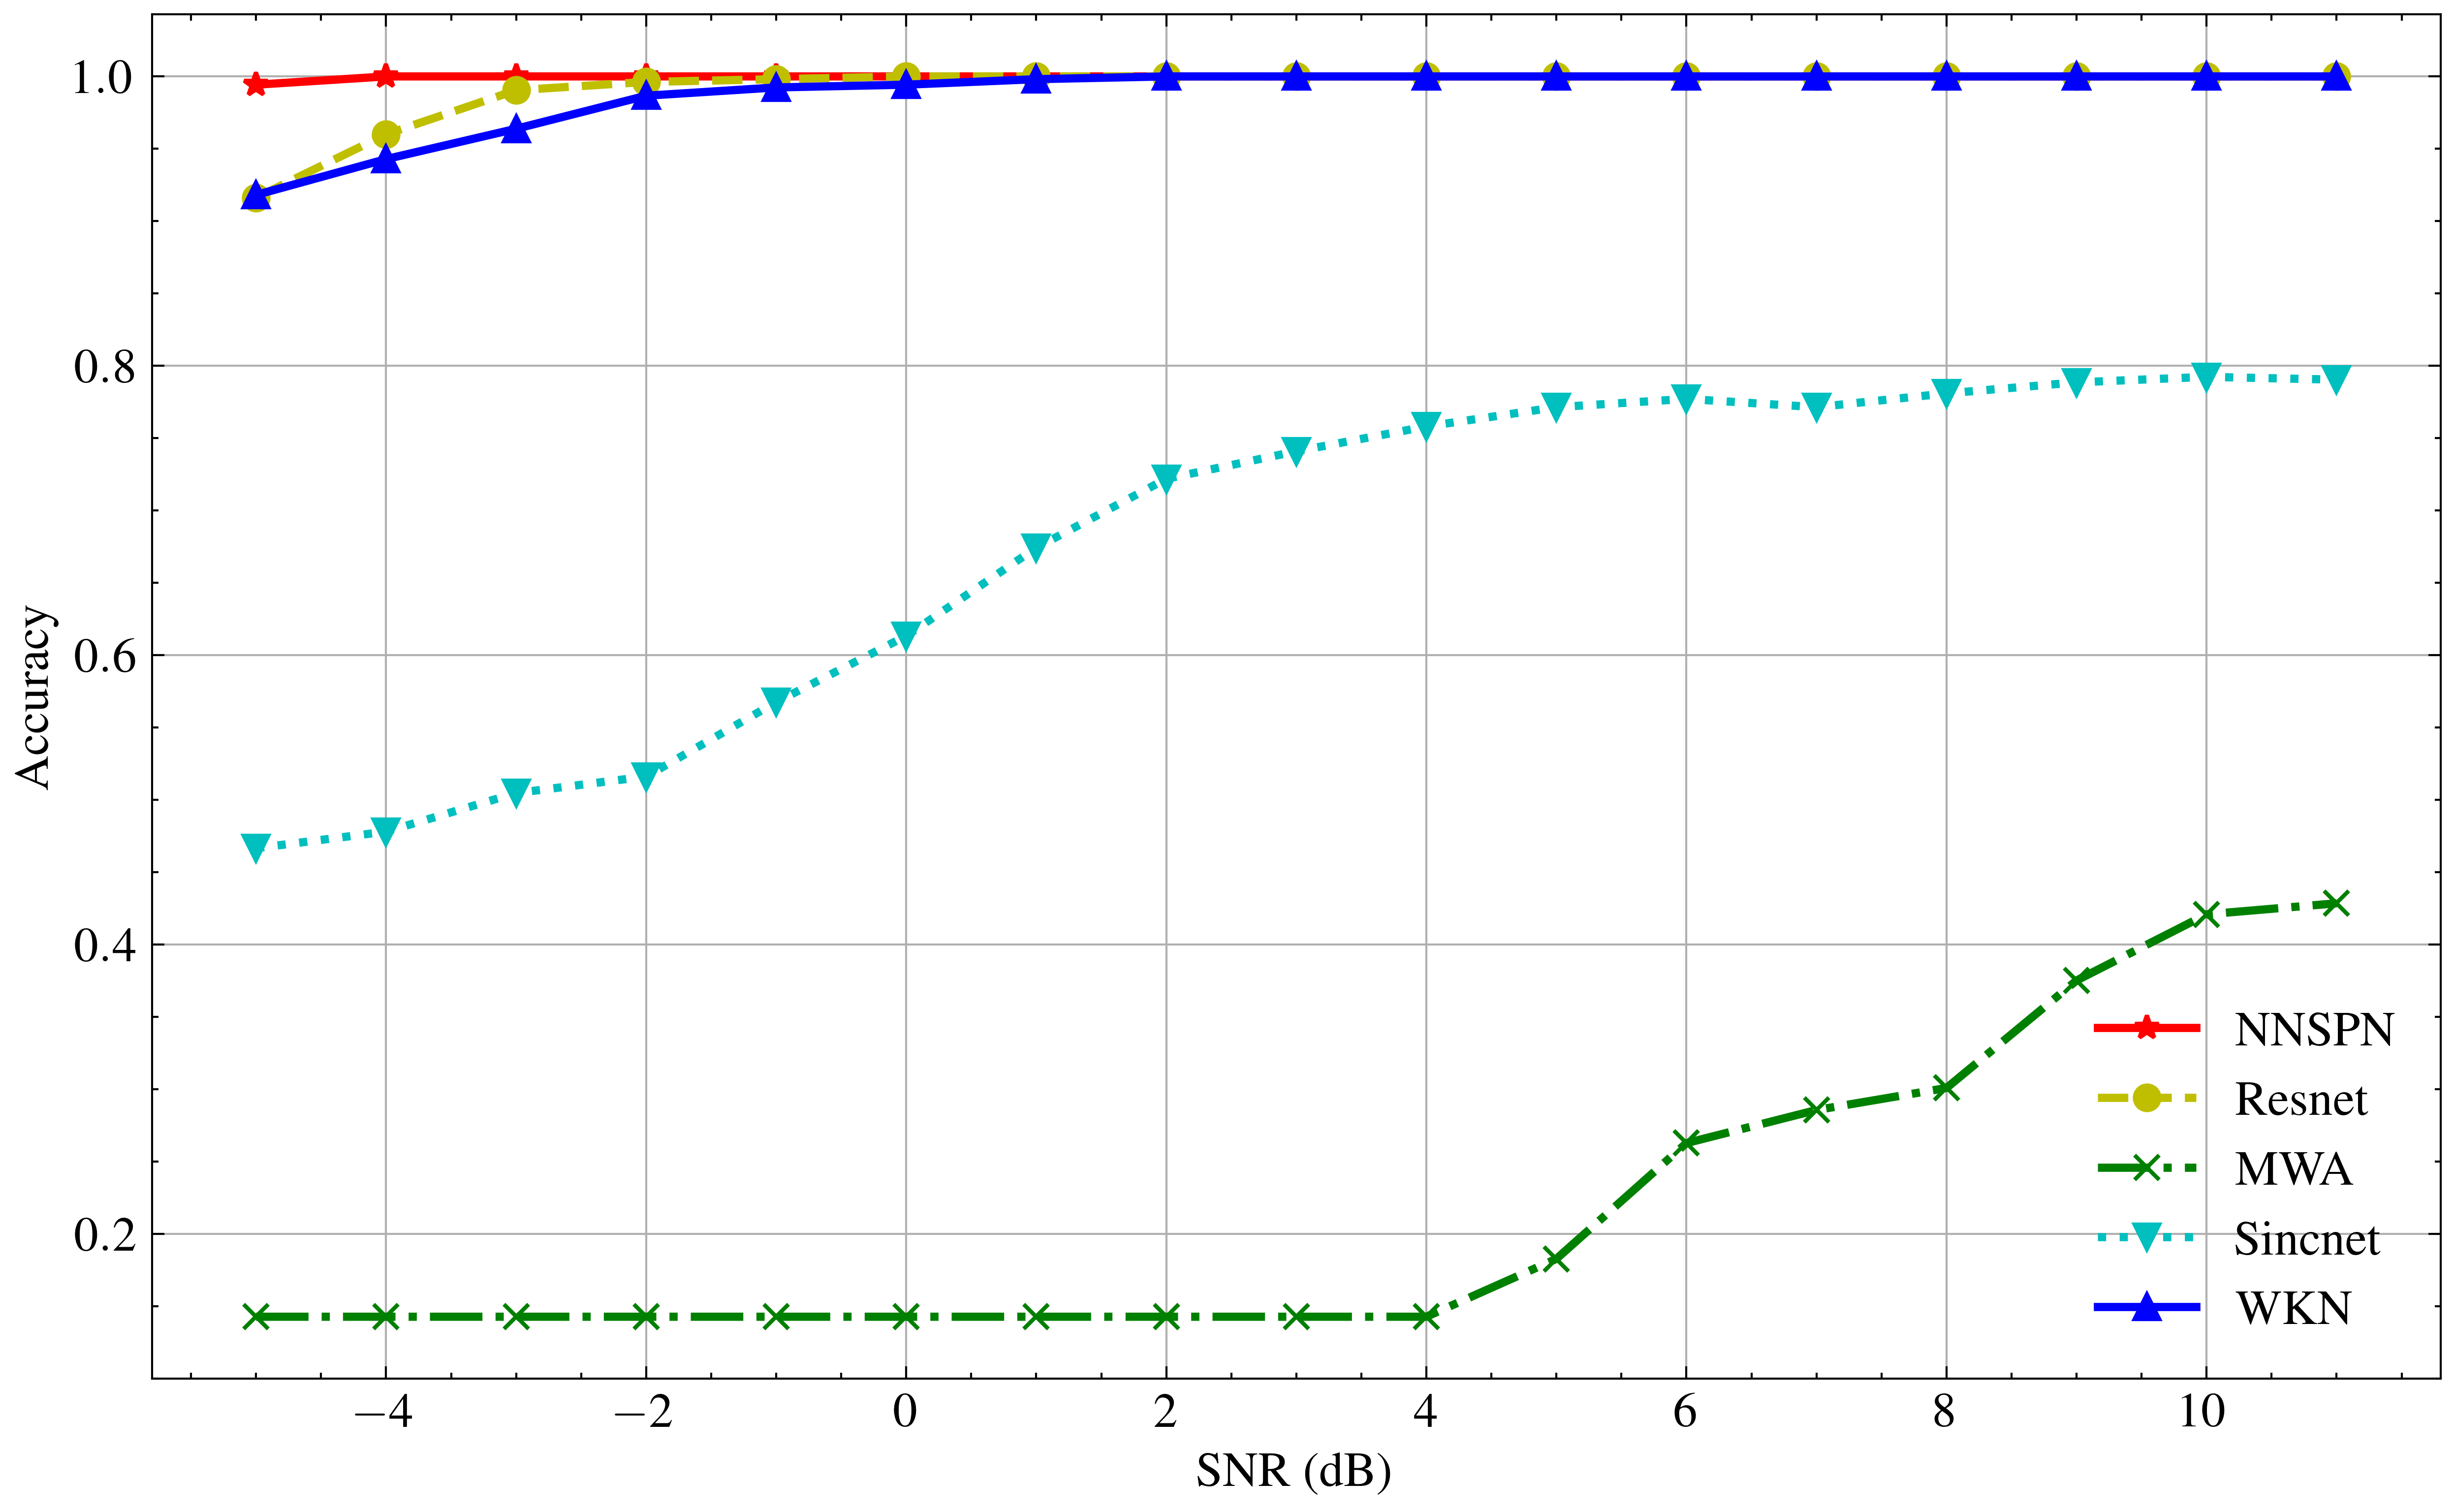

In [15]:
model_dict = {'NNSPN':TSPN,
              'Resnet':resnet,
              'MWA':MWA,
              'Sincnet':Sincnet,
              'WKN':WKN}

snr_levels = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
plot_accuracy_vs_snr(test_data = data, test_labels = labels, model_dict = model_dict, snr_levels = snr_levels, plot_dir='./plot')